# A deep state-space model for a consumer credit risk portfolio

This notebook outlines the development of a deep state-space model for consumer credit risk, built using [pyro.ai](https://pyro.ai/). At its core, the model employs Monte Carlo simulations for each loan, progressing through monthly timesteps. The hidden state at each step represents the loan’s status, with all accounts initially starting as current. From there, loans may transition to early payoff, arrears, or more commonly, remain current and advance to the next month.

The model requires a single primary input: a vector of anticipated cashflows, representing the loan’s installment schedule. The output used for training is the corresponding sequence of realized cashflows, i.e., the actual payments made. Behind the scenes, the model also trains an embedding based on the loan account identifier, which effectively captures the performance characteristics of each specific loan. This embedding serves several purposes, including:
- Simulating the performance of the existing portfolio.
- Extending the installment schedule to maturity to estimate the portfolio’s value if allowed to run off.
- Providing a low-dimensional representation of loan performance, enabling broader analysis beyond traditional good/bad account classifications for training applicant-level models.
- Reducing to a single risk dimension that represents the probability of default over any given time horizon.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import torch
import torch.nn.functional as F
import pyro

In [4]:
from monteloanco import Model, Guide, GroupedBatchSampler, tmat_reshape, Template

The pyro model is defined in a `monteloanco.py`. The state transition matrices define the probabilities at each time step, of moving from one loan status to another. The states are numbered 0-7 and represent the account being: paid early, up to date, 1 month late, 2 months late etc. up to 6 months late at which point the loan is assumed to have been charged off.

The first thing the forward step does is a lookup of the embedding based on the account identifier. The embedding is a low dimensional representation of the transition matrix that is parameterised below for each loan in the portfolio. This identifier is then: linearly transformed into 64 dimensional space, passed through an activation function to introduce some non-linearity, another linear function, reshaped into a 8x8 matrix, and finally passed thorugh softmax to ensure probabilities on any given row (i.e. for any given current/previous state) sum to 1. 

We'll instantiate a `Model` here with a single loan, and an embedding length 4 just to show we get from this low dimensional vector all the way through to a 'portfolio-of-one' simulation.

In [5]:
model_demo = Model(embedding_size=3, device='cpu')
hidden_states, sim_pymnts, interest_paid, principal_paid = model_demo.forward(
    batch_id=0,
    batch_idx=torch.tensor([0]), 
    installments=torch.tensor([108.24]), 
    loan_amnt=torch.tensor([5000]), 
    int_rate=torch.tensor([10]),
    demo=True)

loan_embedding = pyro.get_param_store()['embeddings_0'][0]
print(loan_embedding)

tensor([1.3659, 1.9792, 0.7413], grad_fn=<SelectBackward0>)


We then work through the layers of the neural net to produce the transition matrix. Note how our random n-float embedding has been inflated to an 8x8 matrix, where all rows sum to 1.

In [6]:
tmat_demo = tmat_reshape(loan_embedding, pyro.get_param_store()['model.weight1'], pyro.get_param_store()['model.bias1'], device='cpu')
print(tmat_demo)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2350, 0.3392, 0.4258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2782, 0.2174, 0.3143, 0.1900, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2052, 0.2486, 0.1314, 0.2304, 0.1845, 0.0000, 0.0000, 0.0000],
         [0.1621, 0.2511, 0.0762, 0.1519, 0.2244, 0.1343, 0.0000, 0.0000],
         [0.1523, 0.1098, 0.1096, 0.1605, 0.1632, 0.1595, 0.1450, 0.0000],
         [0.0899, 0.1505, 0.2236, 0.1256, 0.0824, 0.1591, 0.0902, 0.0788],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]]],
       grad_fn=<NanToNumBackward0>)


Given what we know about how people behave with respect to credit products, it should be possible to make a reasonable guess at what this matrix might actually look like. For example, if an account was in state 1 (up to date) at step t-1, the probaility of it remaining in state 1 at step t is pretty high, as most customers like to keep their accounts up to date. If the account is in state 6 (5 months in arrears) it's arguably more likely to roll into being charged off than to be immediately paid in full. Take a look at the heatmap below, where the y-axis represents the current state and the x-axis the next. This example is probably a little on the aggressive side in terms of delinquencies to make it a little more interesting.

- 0: Account fully paid, only option here is to remain in fully paid state, hence (0, 0) cell is dark red.
- 1: Account up to date, most likely scenario is the account remains up to date, thus the (1, 1) cell is lighter red, with much lower probabilities of either becoming fully paid, or rolling to 1 month in arrears.
- 2: Account 1 month in arrears. Options are to catch up and move to 1, remain in 2, or roll again (faint red) to status 3.
- 3: Account 2 month in arrears...
- ...
- 7: Default. Status here remains fixed, the account may be written off from an accounting perspective, and any subsequent collections are classed as recoveries and handled separately.

Later we will train this matrix based on the observed loan performance, but for our initial example we can use a hard-coded, but altogether more realistic version.

<Axes: >

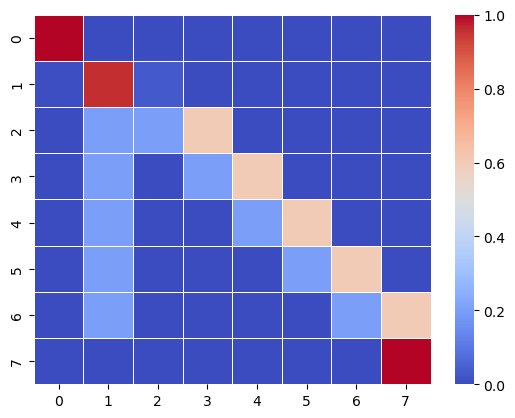

In [7]:
sns.heatmap(Template.DEMO.detach().numpy(), linewidth=0.5, cmap='coolwarm')

Using this matrix we can simulate an imaginary loan of with a schedule of 60 payments of $500 each. The hidden layer (10x series of 60 loan statuses) can be seen in the plot to the left, and the corresponding cashflows to the right. Large spikes in the cashflow indicate replicates where the loan was paid off early, while the smaller spikes where the loan fell into a period of arrears before catching up.

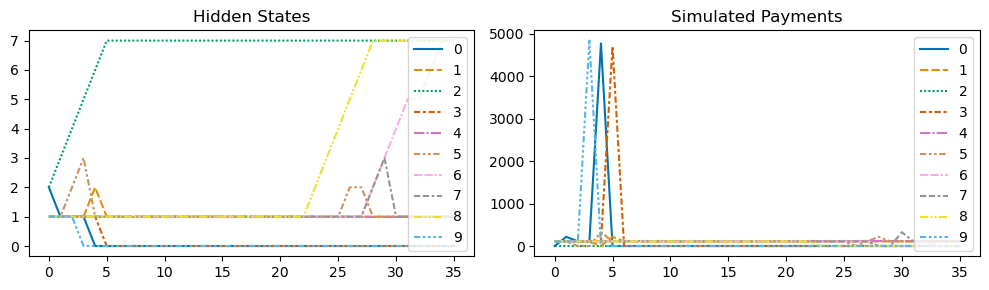

In [8]:
hidden_states, sim_pymnts, interest_paid, principal_paid = model_demo.forward(
    batch_id=0,
    batch_idx=torch.tensor([0]).repeat(10), 
    installments=torch.tensor([108.24]).repeat(10), 
    loan_amnt=torch.tensor([5000]).repeat(10), 
    int_rate=torch.tensor([10]).repeat(10),
    demo=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.lineplot(hidden_states.detach().numpy(), ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy(), ax=ax[1], palette='colorblind')
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

We can now calculate any statistics we might like to calculate on an entire portfolio with respect to just a single loan. Here we simply look at a default rate and the total cashflows, including standard deviations =) though any number of higher order calculations such as NPV or IRR could equally be performed here at loan level.

In [9]:
n = 36
print(f'Default rate by month-{n} is: {torch.mean(hidden_states[n-1]==7, dtype=torch.float).item()}')
print(f'Cashflows expected total: {torch.sum(sim_pymnts, dim=0).mean().item()} +/- {torch.sum(sim_pymnts, dim=0).std().item()}')

Default rate by month-36 is: 0.30000001192092896
Cashflows expected total: 3258.024169921875 +/- 1178.4967041015625
